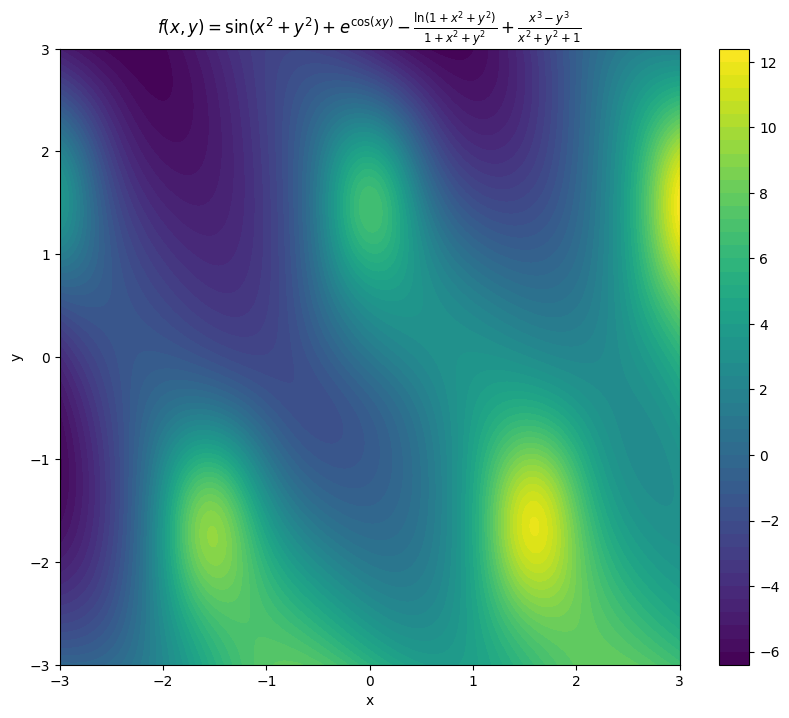

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 定义函数
def f(x, y):
    return (a * np.sin(b * x) * np.cos(c * y) + 
            b * np.cos(a * x) * np.sin(c * y) + 
            c * np.exp(a * np.cos(b * x) * np.sin(c * y)) - 
            np.log(1 + a * x**2 + b * y**2) / (1 + c * x**2 + y**2) + 
            (a * x**3 - b * y**3) / (x**2 + c * y**2 + 1))

a = 2
b = 2
c = 1
# 定义网格
x = np.linspace(-3, 3, 400)
y = np.linspace(-3, 3, 400)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# 绘制图像
plt.figure(figsize=(10, 8))
contour = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.title(r'$f(x, y) = \sin(x^2 + y^2) + e^{\cos(xy)} - \frac{\ln(1 + x^2 + y^2)}{1 + x^2 + y^2} + \frac{x^3 - y^3}{x^2 + y^2 + 1}$')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, bath_normal=False):
        super(DoubleConv, self).__init__()
        channels = out_channels // 2
        if in_channels > out_channels:
            channels = in_channels // 2

        layers = [
            # in_channels：输入通道数
            # channels：输出通道数
            # kernel_size：卷积核大小
            # stride：步长
            # padding：边缘填充
            nn.Conv3d(in_channels, channels, kernel_size=3, stride=1, padding=0),
            nn.ReLU(True),

            nn.Conv3d(channels, out_channels, kernel_size=3, stride=1, padding=0),
            nn.ReLU(True)
        ]
        if bath_normal: # 如果要添加BN层
            layers.insert(1, nn.BatchNorm3d(channels))
            layers.insert(len(layers) - 1, nn.BatchNorm3d(out_channels))

        # 构造序列器
        self.double_conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.double_conv(x)

class DownSampling(nn.Module):
    def __init__(self, in_channels, out_channels, batch_normal=False):
        super(DownSampling, self).__init__()
        self.maxpool_to_conv = nn.Sequential(
            nn.MaxPool3d(kernel_size=2, stride=2),
            DoubleConv(in_channels, out_channels, batch_normal)
        )

    def forward(self, x):
        return self.maxpool_to_conv(x)

class UpSampling(nn.Module):
    def __init__(self, in_channels, out_channels, batch_normal=False, bilinear=True):
        super(UpSampling, self).__init__()
        if bilinear:
            # 采用双线性插值的方法进行上采样
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            # 采用反卷积进行上采样
            self.up = nn.ConvTranspose3d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels + in_channels // 2, out_channels, batch_normal)

    # inputs1：上采样的数据（对应图中黄色箭头传来的数据）
    # inputs2：特征融合的数据（对应图中绿色箭头传来的数据）
    def forward(self, inputs1, inputs2):
        # 进行一次up操作
        inputs1 = self.up(inputs1)

        # 进行特征融合
        outputs = torch.cat([inputs1, inputs2], dim=1)
        outputs = self.conv(outputs)
        return outputs

class LastConv(nn.Module):
    def __init__(self, in_channels, out_channels ):
        super(LastConv, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1 )

    def forward(self, x):
        return self.conv(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels, num_classes=1, batch_normal=False, bilinear=True):
        super(UNet3D, self).__init__()
        self.in_channels = in_channels
        self.batch_normal = batch_normal
        self.bilinear = bilinear

        self.inputs = DoubleConv(in_channels, 64, self.batch_normal)
        self.down_1 = DownSampling(64, 128, self.batch_normal)
        self.down_2 = DownSampling(128, 256, self.batch_normal)
        self.down_3 = DownSampling(256, 512, self.batch_normal)

        self.up_1 = UpSampling(512, 256, self.batch_normal, self.bilinear)
        self.up_2 = UpSampling(256, 128, self.batch_normal, self.bilinear)
        self.up_3 = UpSampling(128, 64, self.batch_normal, self.bilinear)
        self.outputs = LastConv(64, num_classes)

    def forward(self, x):
        # down 部分
        x1 = self.inputs(x)
        x2 = self.down_1(x1)
        x3 = self.down_2(x2)
        x4 = self.down_3(x3)

        # up部分
        x5 = self.up_1(x4, x3)
        x6 = self.up_2(x5, x2)
        x7 = self.up_3(x6, x1)
        x = self.outputs(x7)

        return x


In [4]:
model = UNet3D(in_channels=1, num_classes=1, batch_normal=False, bilinear=True)
input_tensor = torch.randn(1,1,128,128,128)  # Batch size 1, 1 channel, 40x40 image
output = model(input_tensor)
output.shape

NotImplementedError: Got 5D input, but bilinear mode needs 4D input

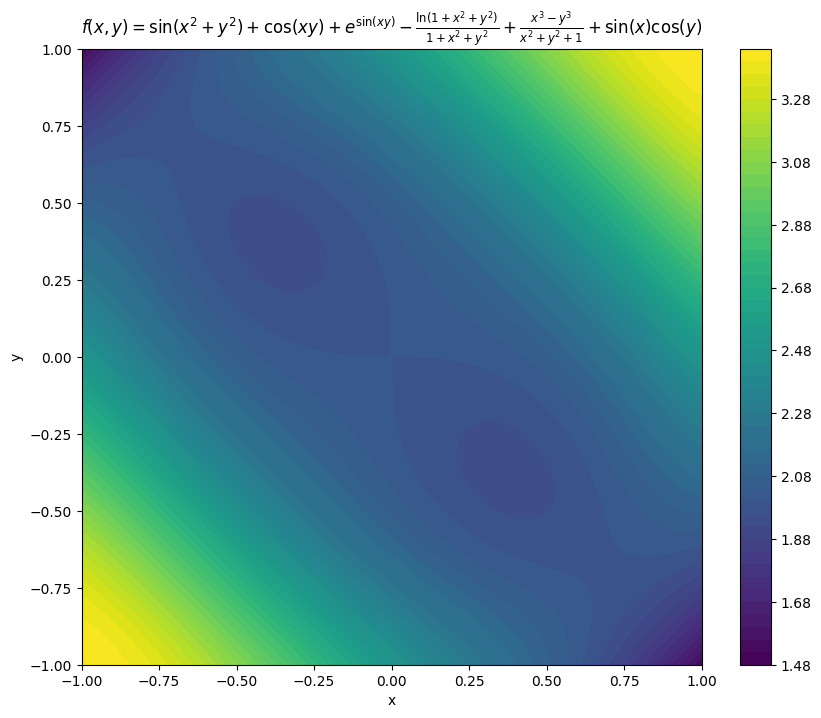

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 定义函数
def f(x, y):
    return np.sin(x**2 + y**2) + np.cos(x*y) + np.exp(np.sin(x*y)) - np.log(1 + x**2 + y**2) / (1 + x**2 + y**2)

# 定义网格
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# 绘制图像
plt.figure(figsize=(10, 8))
contour = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.title(r'$f(x, y) = \sin(x^2 + y^2) + \cos(xy) + e^{\sin(xy)} - \frac{\ln(1 + x^2 + y^2)}{1 + x^2 + y^2} + \frac{x^3 - y^3}{x^2 + y^2 + 1} + \sin(x) \cos(y)$')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [10]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# 网格大小
N = 3
h = 1.0 / (N + 1)

# 创建右手边的源项 f
f = np.ones((N, N))

# 创建系数矩阵 A
diagonals = [-4*np.ones(N*N), np.ones(N*N-1), np.ones(N*N-1), np.ones(N*N-N), np.ones(N*N-N)]
offsets = [0, -1, 1, -N, N]
A = diags(diagonals, offsets, shape=(N*N, N*N)).toarray()

# Dirichlet 边界条件
phi_D = 0.0

# Neumann 边界条件
g = 1.0  # 假设 Neumann 边界条件的值为常数 1.0

for i in range(N):
    for j in range(N):
        if i == 0:  # 下边界
            A[i*N + j, i*N + j] = -3
            A[i*N + j, (i+1)*N + j] = 4
            A[i*N + j, (i+2)*N + j] = -1
            f[i, j] -= 2 * g * h  # 修改右手边向量
        elif i == N-1:  # 上边界
            A[i*N + j, i*N + j] = -3
            A[i*N + j, (i-1)*N + j] = 4
            A[i*N + j, (i-2)*N + j] = -1
            f[i, j] += 2 * g * h  # 修改右手边向量
        elif j == 0:  # 左边界
            A[i*N + j, i*N + j] = 1
            f[i, j] = phi_D
        elif j == N-1:  # 右边界
            A[i*N + j, i*N + j] = 1
            f[i, j] = phi_D

# 将 f 展平为一维向量
b = (h**2) * f.flatten()

import time
starttime=time.time()
# 求解线性系统
phi = spsolve(A, b)
endtime = time.time()
print(endtime-starttime)

# 将解重新整形为二维数组
phi = phi.reshape((N, N))

# 打印解
print(phi)


0.00034332275390625
[[ 0.01327651  0.01146571  0.05893377]
 [ 0.00249873 -0.02509014  0.04197242]
 [-0.04961886 -0.09379744 -0.02619718]]


/tmp/ipykernel_1851748/677255023.py:48: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  phi = spsolve(A, b)


In [11]:
A

array([[-3.,  1.,  0.,  4.,  0.,  0., -1.,  0.,  0.],
       [ 1., -3.,  1.,  0.,  4.,  0.,  0., -1.,  0.],
       [ 0.,  1., -3.,  1.,  0.,  4.,  0.,  0., -1.],
       [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  1., -4.,  1.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.],
       [-1.,  0.,  0.,  4.,  0.,  1., -3.,  1.,  0.],
       [ 0., -1.,  0.,  0.,  4.,  0.,  1., -3.,  1.],
       [ 0.,  0., -1.,  0.,  0.,  4.,  0.,  1., -3.]])

In [12]:
A.shape

(9, 9)

In [21]:
import numpy as np

ac = np.load("/home/pengyu.zhang/project/data/kf_2d_re1000_256_40seed.npy")


In [23]:
ac.shape

(40, 320, 256, 256)

In [20]:
ac['scale']

array(4.7869444, dtype=float32)

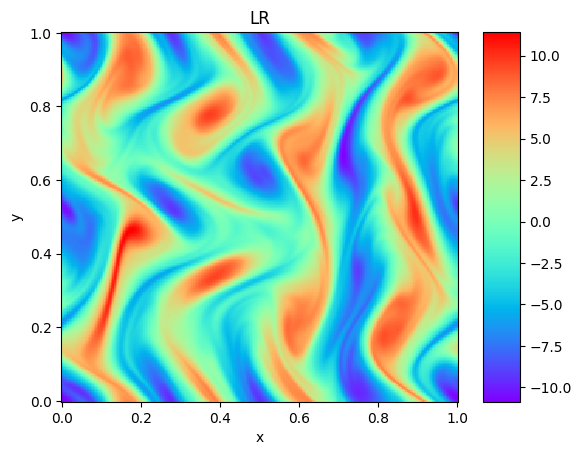

In [37]:
import matplotlib.pyplot as plt
plt.plot()
N_low = 256
h_low = 1/(N_low-1)
x_low = np.arange(0,1.0001,h_low)
y_low = np.arange(0,1.0001,h_low)
plt.pcolormesh(x_low, y_low, ac[1][10], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [1]:
import numpy as np
from torch.utils.tensorboard import SummaryWriter

In [3]:
import torch
from torch import nn
from torch.nn import functional as F

# 上采样+拼接
class Up(nn.Module):
    def __init__(self,in_channels,out_channels,bilinear=True):
        '''
        :param in_channels: 输入通道数
        :param out_channels:  输出通道数
        :param bilinear: 是否采用双线性插值，默认采用
        '''
        super(Up, self).__init__()
        if bilinear:
            # 双线性差值
            self.up = nn.Upsample(scale_factor=2,mode='bilinear',align_corners=True)
            self.conv = doubleConv(in_channels,out_channels,in_channels//2) # 拼接后为1024，经历第一个卷积后512
        else:
            # 转置卷积实现上采样
            # 输出通道数减半，宽高增加一倍
            self.up = nn.ConvTranspose2d(in_channels,out_channels//2,kernel_size=2,stride=2)
            self.conv = doubleConv(in_channels,out_channels)

    def forward(self,x1,x2):
        # 上采样
        x1 = self.up(x1)
        # 拼接
        x = torch.cat([x1,x2],dim=1)
        # 经历双卷积
        x = self.conv(x)
        return x

# 双卷积层
def doubleConv(in_channels,out_channels,mid_channels=None):
    '''
    :param in_channels: 输入通道数 
    :param out_channels: 双卷积后输出的通道数
    :param mid_channels: 中间的通道数，这个主要针对的是最后一个下采样和上采样层
    :return: 
    '''
    if mid_channels is None:
        mid_channels = out_channels
    layer = []
    layer.append(nn.Conv2d(in_channels,mid_channels,kernel_size=3,padding=1,bias=False))
    layer.append(nn.BatchNorm2d(mid_channels))
    layer.append(nn.ReLU(inplace=True))
    layer.append(nn.Conv2d(mid_channels,out_channels,kernel_size=3,padding=1,bias=False))
    layer.append(nn.BatchNorm2d(out_channels))
    layer.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layer)

# 下采样
def down(in_channels,out_channels):
    # 池化 + 双卷积
    layer = []
    layer.append(nn.MaxPool2d(2,stride=2))
    layer.append(doubleConv(in_channels,out_channels))
    return nn.Sequential(*layer)

# 整个网络架构
class U_net(nn.Module):
    def __init__(self,in_channels,out_channels,bilinear=True,base_channel=64):
        '''
        :param in_channels: 输入通道数，一般为3，即彩色图像
        :param out_channels: 输出通道数，即网络最后输出的通道数，一般为2，即进行2分类
        :param bilinear: 是否采用双线性插值来上采样，这里默认采取
        :param base_channel: 第一个卷积后的通道数，即64
        '''
        super(U_net, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bilinear = bilinear

        # 输入
        self.in_conv = doubleConv(self.in_channels,base_channel) # 1,64
        # 下采样
        self.down1 = down(base_channel,base_channel*2) # 64,128
        self.down2 = down(base_channel*2,base_channel*4) #128,256
        # 最后一个下采样，通道数不翻倍（因为双线性差值，不会改变通道数的，为了可以简单拼接，就不改变通道数）
        # 当然，是否采取双线新差值，还是由我们自己决定
        factor = 2  if self.bilinear else 1
        self.down3 = down(base_channel*4,base_channel*8 // factor) # 256,256
        # 上采样 + 拼接
        self.up1 = Up(base_channel*8 ,base_channel*4 // factor,self.bilinear) 
        self.up2 = Up(base_channel*4 ,base_channel*2 // factor,self.bilinear)
        self.up3 = Up(base_channel*2 ,base_channel,self.bilinear)
        # 输出
        self.out = nn.Conv2d(in_channels=base_channel,out_channels=self.out_channels,kernel_size=1)

    def forward(self,x):
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        # 不要忘记拼接
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        out = self.out(x)

        return out

In [5]:
import torch
from torch import nn
from torch.nn import functional as F

# 上采样+拼接
class Up(nn.Module):
    def __init__(self,in_channels,out_channels,bilinear=True):
        '''
        :param in_channels: 输入通道数
        :param out_channels:  输出通道数
        :param bilinear: 是否采用双线性插值，默认采用
        '''
        super(Up, self).__init__()
        if bilinear:
            # 双线性差值
            self.up = nn.Upsample(scale_factor=2,mode='trilinear',align_corners=True)
            self.conv = doubleConv(in_channels,out_channels,in_channels//2) # 拼接后为1024，经历第一个卷积后512
        else:
            # 转置卷积实现上采样
            # 输出通道数减半，宽高增加一倍
            self.up = nn.ConvTranspose3d(in_channels,out_channels//2,kernel_size=2,stride=2)
            self.conv = doubleConv(in_channels,out_channels)

    def forward(self,x1,x2):
        # 上采样
        x1 = self.up(x1)
        # 拼接
        x = torch.cat([x1,x2],dim=1)
        # 经历双卷积
        x = self.conv(x)
        return x

# 双卷积层
def doubleConv(in_channels,out_channels,mid_channels=None):
    '''
    :param in_channels: 输入通道数 
    :param out_channels: 双卷积后输出的通道数
    :param mid_channels: 中间的通道数，这个主要针对的是最后一个下采样和上采样层
    :return: 
    '''
    if mid_channels is None:
        mid_channels = out_channels
    layer = []
    layer.append(nn.Conv3d(in_channels,mid_channels,kernel_size=3,padding=1,bias=False))
    layer.append(nn.BatchNorm3d(mid_channels))
    layer.append(nn.ReLU(inplace=True))
    layer.append(nn.Conv3d(mid_channels,out_channels,kernel_size=3,padding=1,bias=False))
    layer.append(nn.BatchNorm3d(out_channels))
    layer.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layer)

# 下采样
def down(in_channels,out_channels):
    # 池化 + 双卷积
    layer = []
    layer.append(nn.MaxPool3d(2,stride=2))
    layer.append(doubleConv(in_channels,out_channels))
    return nn.Sequential(*layer)

# 整个网络架构
class U_net(nn.Module):
    def __init__(self,in_channels,out_channels,bilinear=True,base_channel=64):
        '''
        :param in_channels: 输入通道数，一般为3，即彩色图像
        :param out_channels: 输出通道数，即网络最后输出的通道数，一般为2，即进行2分类
        :param bilinear: 是否采用双线性插值来上采样，这里默认采取
        :param base_channel: 第一个卷积后的通道数，即64
        '''
        super(U_net, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bilinear = bilinear

        # 输入
        self.in_conv = doubleConv(self.in_channels,base_channel) # 1,64
        # 下采样
        self.down1 = down(base_channel,base_channel*2) # 64,128
        self.down2 = down(base_channel*2,base_channel*4) #128,256
        # 最后一个下采样，通道数不翻倍（因为双线性差值，不会改变通道数的，为了可以简单拼接，就不改变通道数）
        # 当然，是否采取双线新差值，还是由我们自己决定
        factor = 2  if self.bilinear else 1
        self.down3 = down(base_channel*4,base_channel*8 // factor) # 256,256
        # 上采样 + 拼接
        self.up1 = Up(base_channel*8 ,base_channel*4 // factor,self.bilinear) 
        self.up2 = Up(base_channel*4 ,base_channel*2 // factor,self.bilinear)
        self.up3 = Up(base_channel*2 ,base_channel,self.bilinear)
        # 输出
        self.out = nn.Conv3d(in_channels=base_channel,out_channels=self.out_channels,kernel_size=1)

    def forward(self,x):
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        # 不要忘记拼接
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        out = self.out(x)

        return out

In [7]:
model = U_net(1,1)
input_tensor = torch.randn(3,1, 40,40,40)  # Batch size 1, 1 channel, 40x40 image
output = model(input_tensor)
output.shape

torch.Size([3, 1, 40, 40, 40])

In [2]:
import numpy as np
import os
from PIL import Image

# 定义根文件夹路径
root_folder = "/home/pengyu.zhang/project/data/h_cop_celltopoint/h_cop_celltopoint"  # 根据您的实际情况更改为文件夹的路径
# 创建一个形状为 (8, 120, 256, 256) 的空数组，数据类型为 float64
data = np.empty((42, 450, 256, 256), dtype=np.float64)

# 遍历每个组的左右文件夹
for i in range(410,431,1):  # 根据您的命名规则，从18到21
    for side in ["left"]:
        # 定义当前组左右文件夹路径
        group_folder = os.path.join(root_folder, f"{i}{side}")  # e.g., 18left, 18right, ..., 21left, 21right
        # 遍历当前组文件夹中的每张图片
        for j in range(51, 501):  # 根据您的文件命名规则，从0006到0125
            # 定义当前图片文件路径
            if side == "left":
                image_path = os.path.join(group_folder, f"left_symmetric_{i}h.{j:04d}.bmp")  # e.g., left_symmetric_18m.0006.bmp, ..., left_symmetric_21m.0125.bmp
            else:
                image_path = os.path.join(group_folder, f"right_{i}h.{j:04d}.bmp")  # e.g., right_18m.0006.bmp, ..., right_21m.0125.bmp  
            # 读取图像
            # image = Image.open(image_path)
            image = Image.open(image_path).convert("L")
            # 检查图像是否成功读取
            if image is not None:
                # 将图像数据填充到数组中
                index_i = (i - 410)//1  # 将18-21映射到数组的索引0-3
                index_j = j - 51  # 将0006-0125映射到数组的索引0-119
                # data[index_i , index_j] = np.array(image,dtype=np.float64)
                data[index_i * 2 + (1 if side == "right" else 0), index_j] = np.array(image,dtype=np.float64)
            else:
                print(f"Failed to read image: {image_path}")

# 保存为.npy文件
np.save("/home/pengyu.zhang/project/data/high_res.npy", data)

In [31]:
for i in range(410,431,1):  # 根据您的命名规则，从18到21
    for side in ["right","left"]:
        # 定义当前组左右文件夹路径
        group_folder = os.path.join(root_folder, f"{i}{side}")  # e.g., 18left, 18right, ..., 21left, 21right
        # 遍历当前组文件夹中的每张图片
        for j in range(51, 501):  # 根据您的文件命名规则，从0006到0125
            # 定义当前图片文件路径
            if side == "left":
                image_path = os.path.join(group_folder, f"left_symmetric_{i}h.{j:04d}.bmp")  # e.g., left_symmetric_18m.0006.bmp, ..., left_symmetric_21m.0125.bmp
            else:
                image_path = os.path.join(group_folder, f"right_{i}h.{j:04d}.bmp")  # e.g., right_18m.0006.bmp, ..., right_21m.0125.bmp  
            # 读取图像
            # image = Image.open(image_path)
            if i == 410 and j == 51 and side == "left":
                print(image_path)
                image = Image.open(image_path).convert("L")
                # 将图像数据填充到数组中
                index_i = (i - 410)//1  # 将18-21映射到数组的索引0-3
                index_j = j - 51  # 将0006-0125映射到数组的索引0-119
                # data[index_i , index_j] = np.array(image,dtype=np.float64)
                data[index_i * 2 + (1 if side == "right" else 0), index_j] = np.array(image,dtype=np.float64)

/home/pengyu.zhang/project/data/h_cop_celltopoint/h_cop_celltopoint/410left/left_symmetric_410h.0051.bmp


In [3]:
import numpy as np
a=np.load("/home/pengyu.zhang/project/data/high_res_left.npy")


In [4]:
a.shape

(21, 450, 256, 256)

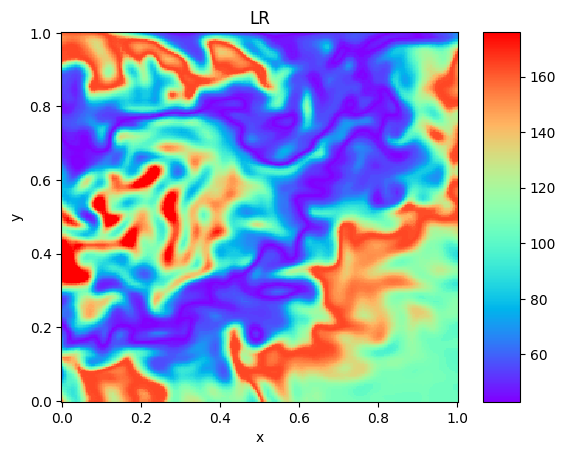

In [7]:
import matplotlib.pyplot as plt
plt.plot()
N_low = 256
h_low = 1/(N_low-1)
x_low = np.arange(0,1.0001,h_low)
y_low = np.arange(0,1.0001,h_low)
plt.pcolormesh(x_low, y_low, a[-1][-1], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

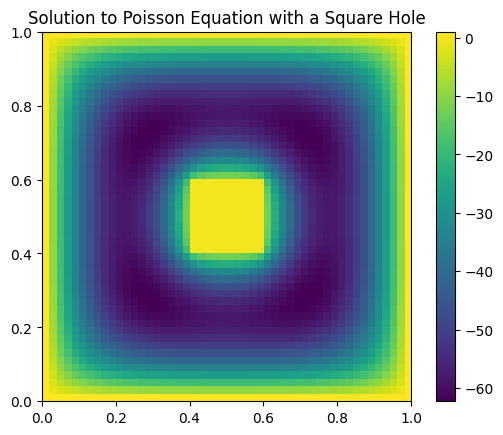

In [1]:
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt

def initialize_grid(nx, ny, hole):
    """ Initialize the grid with boundary conditions and a hole in the middle. """
    u = np.zeros((nx, ny))
    f = np.ones((nx, ny))

    # Define the hole
    hx, hy, hw, hh = hole
    u[hx:hx+hw, hy:hy+hh] = np.nan  # Use NaN to represent the hole

    return u, f

def construct_matrix_A(nx, ny, hole):
    """ Construct the coefficient matrix A for the Poisson equation. """
    N = nx * ny
    A = scipy.sparse.lil_matrix((N, N))
    
    for i in range(nx):
        for j in range(ny):
            idx = i * ny + j
            if np.isnan(u[i, j]):
                A[idx, idx] = 1  # Hole point
            else:
                if i == 0 or i == nx-1 or j == 0 or j == ny-1:
                    A[idx, idx] = 1  # Boundary point
                else:
                    A[idx, idx] = -4
                    A[idx, idx + 1] = 1
                    A[idx, idx - 1] = 1
                    A[idx, idx + ny] = 1
                    A[idx, idx - ny] = 1
    return A

def construct_vector_b(f, nx, ny, hole):
    """ Construct the right-hand side vector b for the Poisson equation. """
    b = f.flatten()
    
    hx, hy, hw, hh = hole
    for i in range(hx, hx + hw):
        for j in range(hy, hy + hh):
            idx = i * ny + j
            b[idx] = 0  # Hole point
    return b

# Grid size
nx, ny = 50, 50

# Define the hole (x, y, width, height)
hole = (20, 20, 10, 10)

# Initialize the grid and source term
u, f = initialize_grid(nx, ny, hole)

# Construct the coefficient matrix A and right-hand side vector b
A = construct_matrix_A(nx, ny, hole)
b = construct_vector_b(f, nx, ny, hole)

# Convert A to CSR format for efficient solving
A_csr = A.tocsr()

# Solve the linear system Ax = b
x = scipy.sparse.linalg.spsolve(A_csr, b)

# Reshape the solution back to a 2D grid
u = x.reshape((nx, ny))

# Plot the solution
plt.imshow(u, extent=[0, 1, 0, 1], origin='lower', cmap='viridis')
plt.colorbar()
plt.title('Solution to Poisson Equation with a Square Hole')
plt.show()


In [12]:
import cv2
img_l = cv2.resize(u, (100,100), interpolation=cv2.INTER_CUBIC)

In [13]:
img_l.shape

(100, 100)

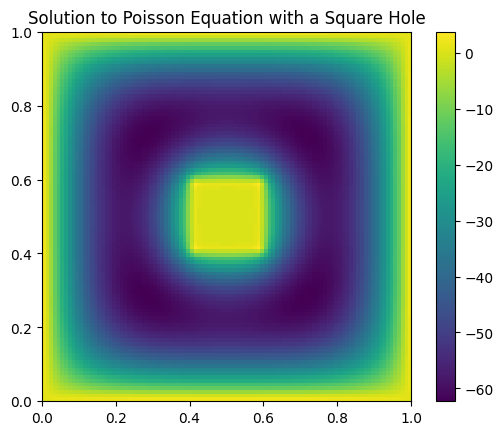

In [14]:
plt.imshow(img_l, extent=[0, 1, 0, 1], origin='lower', cmap='viridis')
plt.colorbar()
plt.title('Solution to Poisson Equation with a Square Hole')
plt.show()


ValueError: The rows of 'x' must be equal

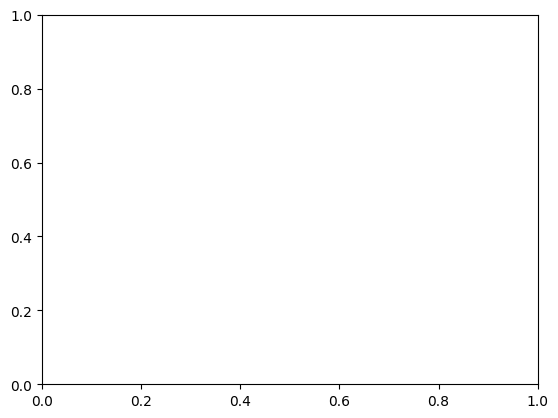

In [1]:
import numpy as np
import matplotlib.pyplot as plt

R = 1.0

L = 5.0
N = 100
dx = L/N
x = np.linspace(-L,L,N+1)

T = 100.0
M = 10000
dt = T/M

nu = 0.1

u = np.zeros((N+1,N+1))
v = np.zeros((N+1,N+1))

u[0,:] = 0
u[-1,:] = 0
u[:,0] = 0
u[:,-1] = 0

v[0,:] = 0
v[-1,:] = 0
v[:,0] = 0
v[:,-1] = 0

for i in range(M):
    u[1:-1,1:-1] = u[1:-1,1:-1] + nu*dt/dx**2*(u[2:,1:-1] - 2*u[1:-1,1:-1] + u[:-2,1:-1] + u[1:-1,2:] - 2*u[1:-1,1:-1] + u[1:-1,:-2]) - dt/dx * (u[1:-1,1:-1]*(u[2:,1:-1] - u[:-2,1:-1]) + v[1:-1,1:-1]*(u[1:-1,2:] - u[1:-1,:-2]))
    v[1:-1,1:-1] = v[1:-1,1:-1] + nu*dt/dx**2*(v[2:,1:-1] - 2*v[1:-1,1:-1] + v[:-2,1:-1] + v[1:-1,2:] - 2*v[1:-1,1:-1] + v[1:-1,:-2]) - dt/dx * (u[1:-1,1:-1]*(v[2:,1:-1] - v[:-2,1:-1]) + v[1:-1,1:-1]*(v[1:-1,2:] - v[1:-1,:-2]))

    u[0,:] = 0
    u[-1,:] = 0
    u[:,0] = 0
    u[:,-1] = 0

    v[0,:] = 0
    v[-1,:] = 0
    v[:,0] = 0
    v[:,-1] = 0

    for k in range(N+1):
        for l in range(N+1):
            if (x[k]**2 + x[l]**2 <= R**2):
                u[k,l] = 0
                v[k,l] = 0

x_ = np.outer(x,np.ones(N+1))
y_ = np.outer(np.ones(N+1),x)
plt.streamplot(x_,y_,u,v)
plt.gca().set_aspect('equal')
plt.show()

In [4]:
N

100

In [2]:
u.shape

(10, 10, 10)

/tmp/ipykernel_1639682/228612336.py:52: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u = spsolve(A, b)


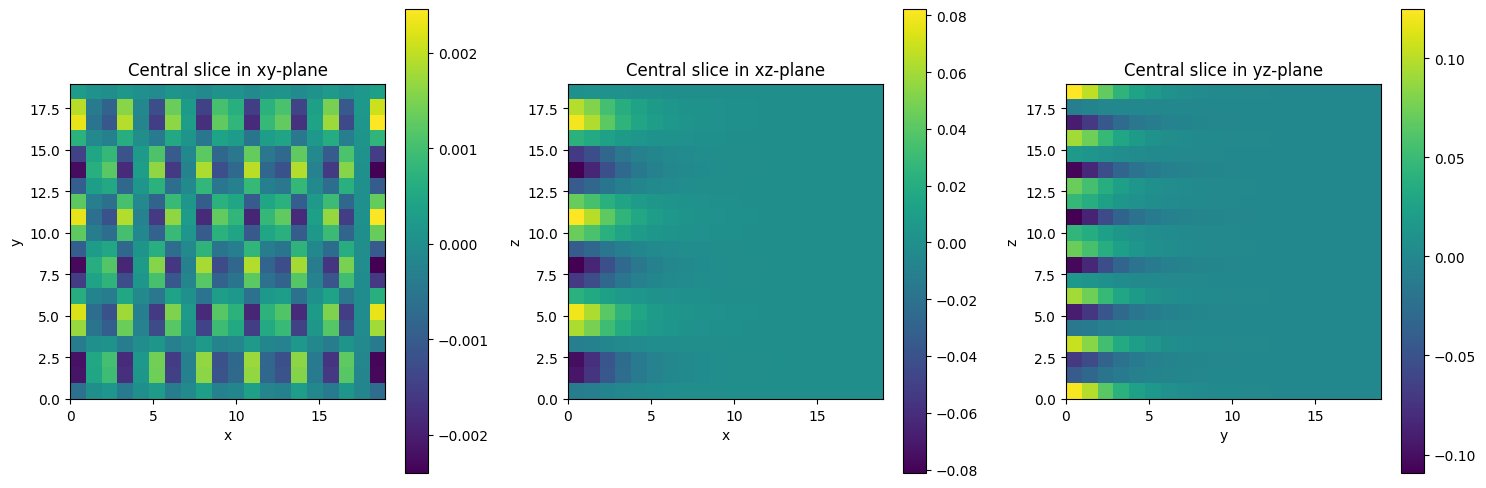

In [3]:
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def generate_poisson_matrix(n):
    """Generates the sparse matrix for the 3D Poisson equation using finite differences."""
    N = n * n * n
    A = lil_matrix((N, N))

    for z in range(n):
        for y in range(n):
            for x in range(n):
                idx = x + y * n + z * n * n

                A[idx, idx] = -6

                if x > 0:
                    A[idx, idx - 1] = 1
                if x < n - 1:
                    A[idx, idx + 1] = 1
                if y > 0:
                    A[idx, idx - n] = 1
                if y < n - 1:
                    A[idx, idx + n] = 1
                if z > 0:
                    A[idx, idx - n * n] = 1
                if z < n - 1:
                    A[idx, idx + n * n] = 1

    return A

def complex_source_term(x, y, z, param1, param2, param3):
    """Defines a complex source term as a function of position and parameters."""
    return np.sin(param1 * x) * np.cos(param2 * y) * np.exp(-param3 * z)

def generate_source_term(n, param1, param2, param3):
    """Generates the source term matrix for the 3D Poisson equation."""
    f = np.zeros((n, n, n))
    for z in range(n):
        for y in range(n):
            for x in range(n):
                f[x, y, z] = complex_source_term(x, y, z, param1, param2, param3)
    return f

def solve_poisson_3d(n, param1, param2, param3):
    """Solves the 3D Poisson equation using finite differences."""
    A = generate_poisson_matrix(n)
    f = generate_source_term(n, param1, param2, param3)
    b = f.flatten()
    u = spsolve(A, b)
    return u.reshape((n, n, n))

def plot_solution(u, n):
    """Plots the solution u using Matplotlib."""
    fig = plt.figure(figsize=(15, 5))

    # Plot a central slice in the xy-plane
    ax1 = fig.add_subplot(131)
    slice_xy = u[:, :, n//2]
    c = ax1.imshow(slice_xy, origin='lower', extent=[0, n-1, 0, n-1], cmap='viridis')
    fig.colorbar(c, ax=ax1)
    ax1.set_title('Central slice in xy-plane')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')

    # Plot a central slice in the xz-plane
    ax2 = fig.add_subplot(132)
    slice_xz = u[:, n//2, :]
    c = ax2.imshow(slice_xz, origin='lower', extent=[0, n-1, 0, n-1], cmap='viridis')
    fig.colorbar(c, ax=ax2)
    ax2.set_title('Central slice in xz-plane')
    ax2.set_xlabel('x')
    ax2.set_ylabel('z')

    # Plot a central slice in the yz-plane
    ax3 = fig.add_subplot(133)
    slice_yz = u[n//2, :, :]
    c = ax3.imshow(slice_yz, origin='lower', extent=[0, n-1, 0, n-1], cmap='viridis')
    fig.colorbar(c, ax=ax3)
    ax3.set_title('Central slice in yz-plane')
    ax3.set_xlabel('y')
    ax3.set_ylabel('z')

    plt.tight_layout()
    plt.show()

# Example usage
n = 20  # Grid size
param1 = 1.0
param2 = 2.0
param3 = 0.5

# Solve the Poisson equation
u = solve_poisson_3d(n, param1, param2, param3)

# Plot the solution
plot_solution(u, n)


In [4]:
u = np.array([[[1,2,3],[4,5,6],[7,8,9]],[[10,11,12],[13,14,15],[16,17,18]],[[19,20,21],[22,23,24],[25,26,27]]])

In [11]:
u[0][1][0]

4

In [18]:
a = np.random.random((40*40*40,40*40*40))

In [15]:
from scipy.sparse import csr_matrix, linalg
csr_matrix(a)

TypeError: expected 2D array or matrix, not 3D

In [3]:
import scipy.sparse as sp

sp.csr_matrix((80**3,80**3))

<512000x512000 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [40]:
from scipy.sparse import lil_matrix

A = lil_matrix((5,5))

In [42]:
B = lil_matrix((2,2))
B[:,:] = 1

In [43]:
A[2:4,2:4] = B

In [44]:
A.toarray()

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0.]])

In [53]:
B[-1,-1]

1.0

In [51]:
B.toarray()

array([[1., 1.],
       [1., 1.]])

In [4]:
N = 4
from scipy.sparse import lil_matrix


def create_subA(N):

    subA = lil_matrix((N,N))

    subA[0,0] = 1
    subA[-1,-1] = 1

    for i in range(1,N-1):
        subA[i,i-1] = -1
        subA[i,i] = 6
        subA[i,i+1] = -1

    return subA


def create_subB(N):
    subB = lil_matrix((N,N))

    for i in range(1,N-1):
        subB[i,i] = -1

    return subB


def create_subI(N):

    subI = lil_matrix((N,N))

    for i in range(N):
        subI[i,i] = 1

    return subI


def create_bigA(N):

    bigA = lil_matrix((N**2,N**2))

    bigA[0:N,0:N] = create_subI(N)
    bigA[N*(N-1):N*N,N*(N-1):N*N] = create_subI(N)

    for i in range(1,N-1):
        bigA[N*i:N*(i+1),N*(i-1):N*i] = create_subB(N)
        bigA[N*i:N*(i+1),N*i:N*(i+1)] = create_subA(N)
        bigA[N*i:N*(i+1),N*(i+1):N*(i+2)] = create_subB(N)

    return bigA


def create_bigB(N):

    bigB = lil_matrix((N**2,N**2))

    for i in range(1,N-1):
        bigB[N*i:N*(i+1),N*i:N*(i+1)] = create_subB(N)

    return bigB


def create_bigI(N):

    bigI = lil_matrix((N**2,N**2))

    for i in range(N**2):
        bigI[i,i] = 1

    return bigI


def create_A(N):

    A = lil_matrix((N**3,N**3))

    A[0:N**2,0:N**2] = create_bigI(N)
    A[(N**2)*(N-1):N**3,(N**2)*(N-1):N**3] = create_bigI(N)

    bigA = create_bigA(N)
    bigB = create_bigB(N)

    for i in range(1,N-1):
        A[(N**2)*i:(N**2)*(i+1),(N**2)*(i-1):(N**2)*i] = bigB
        A[(N**2)*i:(N**2)*(i+1),(N**2)*i:(N**2)*(i+1)] = bigA
        A[(N**2)*i:(N**2)*(i+1),(N**2)*(i+1):(N**2)*(i+2)] = bigB

    return A

A = create_A(N)

In [5]:
import numpy as np
def create_forcing_term(N, a, b, c, d):

    h = 1/(N-1)
    x = np.arange(0,1.0001,h)
    y = np.arange(0,1.0001,h)
    z = np.arange(0,1.0001,h)

    r = np.ones(N**3) * d

    for i in range(1,N-1):
        for j in range(1,N-1):
            for k in range(1,N-1):
                position = N**2 * i + N * j + k
                r[position] = np.sin(a*np.pi*x[i]) * np.cos(b*np.pi*y[j]) * np.exp(-c*z[k]) + np.sin(b*np.pi*y[j]) * np.cos(c*np.pi*z[k]) * np.exp(-a*x[i]) + np.sin(c*np.pi*z[k]) * np.cos(a*np.pi*x[i]) * np.exp(-b*y[j])

    return r

r = create_forcing_term(N,1,1,1,1)

In [4]:
from scipy.sparse import csr_matrix, linalg, lil_matrix

N = 60

A = create_A(N)

r = create_forcing_term(N,1,1,1,1)

A = A.tocsr()

import time

start = time.time()

w = linalg.spsolve(A,r).reshape((N,N,N))

end = time.time()

print(end-start)

337.06730914115906


In [6]:
from scipy.sparse import csr_matrix, linalg, lil_matrix

N = 15

A = create_A(N)

r = create_forcing_term(N,1,1,1,1)

A = A.tocsr()

import time

start = time.time()

w = linalg.spsolve(A,r).reshape((N,N,N))

end = time.time()

print(end-start)

0.01206517219543457


In [ ]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_high, y_high)
ax1.plot_wireframe(X, Y, z.cpu().data.numpy()[10],color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('SR')
plt.show()

In [ ]:
class DownScale(torch.nn.Module):
    def __init__(self):
        super(DownScale, self).__init__()
        self.layer1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1,padding=1)
        self.layer2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1,padding=1)
        self.layer3 = torch.nn.MaxPool2d(2)
        self.layer4 = torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1,padding=1)
        self.layer5 = torch.nn.MaxPool2d(2)
        self.layer6 = torch.nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1,padding=1)
        self.PReLU = torch.nn.PReLU()
    def forward(self, x):
        x = self.layer1(x)
        x = self.PReLU(x)
        x = self.layer2(x)
        x = self.PReLU(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.PReLU(x)
        x = self.layer5(x)
        x = self.layer6(x)
        return x


In [2]:
import torch
import torch.nn as nn

class DownScale3D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, pool_size=2):
        super(DownScale3D, self).__init__()
        self.layer1 = nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.layer2 = nn.Conv3d(out_channels, out_channels*2, kernel_size=kernel_size, stride=stride, padding=padding)
        self.layer3 = nn.MaxPool3d(kernel_size=pool_size, stride=pool_size)
        self.layer4 = nn.Conv3d(out_channels*2, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.layer5 = nn.MaxPool3d(kernel_size=pool_size, stride=pool_size)
        self.layer6 = nn.Conv3d(out_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.PReLU = torch.nn.PReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.PReLU(x)
        x = self.layer2(x)
        x = self.PReLU(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.PReLU(x)
        x = self.layer5(x)
        x = self.layer6(x)
        return x

# 示例输入
batch_size = 1
in_channels = 1
depth = 60
height = 60
width = 60

# 创建一个随机输入张量
input_tensor = torch.randn(in_channels, depth, height, width)

# 创建下采样模块
downsample = DownScale3D(in_channels, out_channels=32)

# 执行前向传播
output_tensor = downsample(input_tensor)

print("Input shape:", input_tensor.shape)
print("Output shape:", output_tensor.shape)


Input shape: torch.Size([1, 60, 60, 60])
Output shape: torch.Size([1, 15, 15, 15])


In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import cv2
import math
from tqdm import tqdm
from tqdm.std import trange
from torch.utils.data import dataloader
from scipy.sparse import csr_matrix, linalg, lil_matrix


def create_subA(N):

    subA = lil_matrix((N,N))

    subA[0,0] = 1
    subA[-1,-1] = 1

    for i in range(1,N-1):
        subA[i,i-1] = -1
        subA[i,i] = 6
        subA[i,i+1] = -1

    return subA


def create_subB(N):
    subB = lil_matrix((N,N))

    for i in range(1,N-1):
        subB[i,i] = -1

    return subB


def create_subI(N):

    subI = lil_matrix((N,N))

    for i in range(N):
        subI[i,i] = 1

    return subI


def create_bigA(N):

    bigA = lil_matrix((N**2,N**2))

    bigA[0:N,0:N] = create_subI(N)
    bigA[N*(N-1):N*N,N*(N-1):N*N] = create_subI(N)

    for i in range(1,N-1):
        bigA[N*i:N*(i+1),N*(i-1):N*i] = create_subB(N)
        bigA[N*i:N*(i+1),N*i:N*(i+1)] = create_subA(N)
        bigA[N*i:N*(i+1),N*(i+1):N*(i+2)] = create_subB(N)

    return bigA


def create_bigB(N):

    bigB = lil_matrix((N**2,N**2))

    for i in range(1,N-1):
        bigB[N*i:N*(i+1),N*i:N*(i+1)] = create_subB(N)

    return bigB


def create_bigI(N):

    bigI = lil_matrix((N**2,N**2))

    for i in range(N**2):
        bigI[i,i] = 1

    return bigI


def create_A(N):

    A = lil_matrix((N**3,N**3))

    A[0:N**2,0:N**2] = create_bigI(N)
    A[(N**2)*(N-1):N**3,(N**2)*(N-1):N**3] = create_bigI(N)

    bigA = create_bigA(N)
    bigB = create_bigB(N)

    for i in range(1,N-1):
        A[(N**2)*i:(N**2)*(i+1),(N**2)*(i-1):(N**2)*i] = bigB
        A[(N**2)*i:(N**2)*(i+1),(N**2)*i:(N**2)*(i+1)] = bigA
        A[(N**2)*i:(N**2)*(i+1),(N**2)*(i+1):(N**2)*(i+2)] = bigB

    return A


def create_forcing_term(N, a, b, c, d):

    h = 1/(N-1)
    x = np.arange(0,1.0001,h)
    y = np.arange(0,1.0001,h)
    z = np.arange(0,1.0001,h)

    r = np.ones(N**3) * d

    for i in range(1,N-1):
        for j in range(1,N-1):
            for k in range(1,N-1):
                position = N**2 * i + N * j + k
                r[position] = h**2 * (np.sin(a*np.pi*x[i]) * np.cos(b*np.pi*y[j]) * np.exp(-c*z[k]) + np.sin(b*np.pi*y[j]) * np.cos(c*np.pi*z[k]) * np.exp(-a*x[i]) + np.sin(c*np.pi*z[k]) * np.cos(a*np.pi*x[i]) * np.exp(-b*y[j]))

    return r


def generate_data(N,a,b,c,d):

    # Initialisation
    h = 1/(N-1)
    x = np.arange(0,1.0001,h)
    y = np.arange(0,1.0001,h)
    z = np.arange(0,1.0001,h)
    
    # Work out the matrix A
    A = create_A(N)
        
    # Work out the forcing term r
    r = create_forcing_term(N,a,b,c,d)

    w = linalg.spsolve(A,r).reshape((N,N,N))
    
    return w, r, A, x, y, z


In [2]:
def create_I(N):
    
    bigI = lil_matrix((N,N))

    for i in range(N):
        bigI[i,i] = 1

    return bigI

def create_minusI(N):

    minusI = lil_matrix((N,N))

    for i in range(1,N-1):
        minusI[i,i] = -1

    return minusI

def create_minusAI(N,empty_rows):

    minusAI = lil_matrix((N,N))

    num_values = (N-2-empty_rows-2)//2

    for i in range(1,1+num_values):
        minusAI[i,i] = -1
        minusAI[-(i+1),-(i+1)] = -1

    return minusAI

def create_minusBI(N,empty_rows):

    minusBI = lil_matrix((N,N-empty_rows))

    num_values = (N-2-empty_rows-2)//2

    for i in range(1,1+num_values):
        minusBI[i,i] = -1
        minusBI[-(i+1),-(i+1)] = -1

    return minusBI

def create_minusCI(N,empty_rows):

    minusCI = lil_matrix((N-empty_rows,N))

    num_values = (N-2-empty_rows-2)//2

    for i in range(1,1+num_values):
        minusCI[i,i] = -1
        minusCI[-(i+1),-(i+1)] = -1

    return minusCI


def create_minusDI(N,empty_rows):

    minusDI = lil_matrix((N-empty_rows,N-empty_rows))

    num_values = (N-2-empty_rows-2)//2

    for i in range(1,1+num_values):
        minusDI[i,i] = -1
        minusDI[-(i+1),-(i+1)] = -1

    return minusDI


def create_A(N):

    A = lil_matrix((N,N))

    A[0,0] = 1
    A[-1,-1] = 1
    
    for i in range(1,N-1):
        A[i,i] = 4
        A[i,i-1] = -1
        A[i,i+1] = -1

    return A

def create_B(N,empty_rows):

    B = lil_matrix((N,N))

    B[0,0] = 1
    B[-1,-1] = 1

    num_values = (N-2-empty_rows-2)//2

    for i in range(1,1+num_values):

        B[i,i] = 4
        B[i,i-1] = -1
        B[i,i+1] = -1

        B[-(i+1),-(i+1)] = 4
        B[-(i+1),-i] = -1
        B[-(i+1),-(i+2)] = -1

    for i in range(1+num_values,1+num_values+2+empty_rows):
        B[i,i] = 1

    return B

def create_C(N,empty_rows):

    C = lil_matrix((N-empty_rows,N-empty_rows))

    C[0,0] = 1
    C[-1,-1] = 1

    num_values = (N-2-empty_rows-2)//2

    for i in range(1,1+num_values):

        C[i,i] = 4
        C[i,i-1] = -1
        C[i,i+1] = -1

        C[-(i+1),-(i+1)] = 4
        C[-(i+1),-i] = -1
        C[-(i+1),-(i+2)] = -1

    for i in range(1+num_values,1+num_values+2):

        C[i,i] = 1

    return C

def create_bigA(N):

    empty_rows = ((N-1) // 8) * 2 - 1
    dimension = N*(N-empty_rows) + (N-empty_rows)*empty_rows
    bigA = lil_matrix((dimension,dimension))

    I = create_I(N)
    minusI = create_minusI(N)
    minusAI = create_minusAI(N,empty_rows)
    minusBI = create_minusBI(N,empty_rows)
    minusCI = create_minusCI(N,empty_rows)
    minusDI = create_minusDI(N,empty_rows)
    A = create_A(N)
    B = create_B(N,empty_rows)
    C = create_C(N,empty_rows)

    bigA[0:N,0:N] = I

    num_values = (N-2-empty_rows-2)//2

    for i in range(num_values):
        bigA[(i+1)*N:(i+2)*N,i*N:(i+1)*N] = minusI
        bigA[(i+1)*N:(i+2)*N,(i+1)*N:(i+2)*N] = A
        bigA[(i+1)*N:(i+2)*N,(i+2)*N:(i+3)*N] = minusI

    bigA[(1+num_values)*N:(2+num_values)*N,num_values*N:(1+num_values)*N] = minusAI
    bigA[(1+num_values)*N:(2+num_values)*N,(1+num_values)*N:(2+num_values)*N] = B
    bigA[(1+num_values)*N:(2+num_values)*N,(2+num_values)*N:(2+num_values)*N+N-empty_rows] = minusBI

    if empty_rows == 1:
        
        bigA[(2+num_values)*N:(2+num_values)*N+N-empty_rows,(1+num_values)*N:(2+num_values)*N] = minusCI
        bigA[(2+num_values)*N:(2+num_values)*N+N-empty_rows,(2+num_values)*N:(2+num_values)*N+N-empty_rows] = C
        bigA[(2+num_values)*N:(2+num_values)*N+N-empty_rows,(2+num_values)*N+N-empty_rows:(3+num_values)*N+N-empty_rows] = minusCI

    else:

        bigA[(2+num_values)*N:(2+num_values)*N+N-empty_rows,(1+num_values)*N:(2+num_values)*N] = minusCI
        bigA[(2+num_values)*N:(2+num_values)*N+N-empty_rows,(2+num_values)*N:(2+num_values)*N+N-empty_rows] = C
        bigA[(2+num_values)*N:(2+num_values)*N+N-empty_rows,(2+num_values)*N+N-empty_rows:(2+num_values)*N+2*(N-empty_rows)] = minusDI

        for i in range(empty_rows-2):

            bigA[(2+num_values)*N+(i+1)*(N-empty_rows):(2+num_values)*N+(i+2)*(N-empty_rows),(2+num_values)*N+i*(N-empty_rows):(2+num_values)*N+(i+1)*(N-empty_rows)] = minusDI
            bigA[(2+num_values)*N+(i+1)*(N-empty_rows):(2+num_values)*N+(i+2)*(N-empty_rows),(2+num_values)*N+(i+1)*(N-empty_rows):(2+num_values)*N+(i+2)*(N-empty_rows)] = C
            bigA[(2+num_values)*N+(i+1)*(N-empty_rows):(2+num_values)*N+(i+2)*(N-empty_rows),(2+num_values)*N+(i+2)*(N-empty_rows):(2+num_values)*N+(i+3)*(N-empty_rows)] = minusDI

        bigA[(2+num_values)*N+(empty_rows-1)*(N-empty_rows):(2+num_values)*N+empty_rows*(N-empty_rows),(2+num_values)*N+(empty_rows-2)*(N-empty_rows):(2+num_values)*N+(empty_rows-1)*(N-empty_rows)] = minusDI
        bigA[(2+num_values)*N+(empty_rows-1)*(N-empty_rows):(2+num_values)*N+empty_rows*(N-empty_rows),(2+num_values)*N+(empty_rows-1)*(N-empty_rows):(2+num_values)*N+empty_rows*(N-empty_rows)] = C
        bigA[(2+num_values)*N+(empty_rows-1)*(N-empty_rows):(2+num_values)*N+empty_rows*(N-empty_rows),(2+num_values)*N+empty_rows*(N-empty_rows):(3+num_values)*N+empty_rows*(N-empty_rows)] = minusCI

    bigA[(2+num_values)*N+empty_rows*(N-empty_rows):(3+num_values)*N+empty_rows*(N-empty_rows),(2+num_values)*N+(empty_rows-1)*(N-empty_rows):(2+num_values)*N+empty_rows*(N-empty_rows)] = minusBI
    bigA[(2+num_values)*N+empty_rows*(N-empty_rows):(3+num_values)*N+empty_rows*(N-empty_rows),(2+num_values)*N+empty_rows*(N-empty_rows):(3+num_values)*N+empty_rows*(N-empty_rows)] = B
    bigA[(2+num_values)*N+empty_rows*(N-empty_rows):(3+num_values)*N+empty_rows*(N-empty_rows),(3+num_values)*N+empty_rows*(N-empty_rows):(4+num_values)*N+empty_rows*(N-empty_rows)] = minusAI

    for i in range(num_values):
        bigA[(2+num_values)*N+empty_rows*(N-empty_rows)+(i+1)*N:(2+num_values)*N+empty_rows*(N-empty_rows)+(i+2)*N,(2+num_values)*N+empty_rows*(N-empty_rows)+i*N:(2+num_values)*N+empty_rows*(N-empty_rows)+(i+1)*N] = minusI
        bigA[(2+num_values)*N+empty_rows*(N-empty_rows)+(i+1)*N:(2+num_values)*N+empty_rows*(N-empty_rows)+(i+2)*N,(2+num_values)*N+empty_rows*(N-empty_rows)+(i+1)*N:(2+num_values)*N+empty_rows*(N-empty_rows)+(i+2)*N] = A
        bigA[(2+num_values)*N+empty_rows*(N-empty_rows)+(i+1)*N:(2+num_values)*N+empty_rows*(N-empty_rows)+(i+2)*N,(2+num_values)*N+empty_rows*(N-empty_rows)+(i+2)*N:(2+num_values)*N+empty_rows*(N-empty_rows)+(i+3)*N] = minusI

    bigA[dimension-N:dimension,dimension-N:dimension] = I

    return bigA

In [8]:
def create_forcing_term(N):
    """
    Generate the forcing term
    
    Args
    ----------
    N : int
        The size of PDE domain is (N,N)
        
    Outputs
    ----------
    r : ndarray of size (N**2,1)
        The forcing term b
    """
    
    h = 1/(N-1)
    x = np.arange(0,1.0001,h)
    y = np.arange(0,1.0001,h)

    empty_rows = ((N-1) // 8) * 2 - 1
    dimension = N*(N-empty_rows) + (N-empty_rows)*empty_rows
    num_values = (N-2-empty_rows-2)//2

    r = np.zeros(dimension)

    # top row
    i = 1+num_values
    for j in range(1+num_values,1+num_values+empty_rows+2):
        position = i * N + j
        coordinate = (j-(1+num_values))*h
        r[position] = -coordinate * (coordinate-0.25)

    # middle rows
    for k in range(empty_rows):
        i = 1 + num_values + k + 1
        j1 = 1+num_values
        j2 = 1+num_values+empty_rows+1

        coordinate = (i-(1+num_values))*h

        position1 = (2+num_values) * N + k * (N-empty_rows) + 1 + num_values
        position2 = (2+num_values) * N + k * (N-empty_rows) + 1 + num_values + 1

        r[position1] = -coordinate * (coordinate-0.25)
        r[position2] = -coordinate * (coordinate-0.25)

    # bottom row
    i = 1 + num_values + 1 + empty_rows
    for j in range(1+num_values,1+num_values+empty_rows+2):
        position = (2+num_values) * N + empty_rows*(N-empty_rows) + j
        coordinate = (j-(1+num_values))*h
        r[position] = -coordinate * (coordinate-0.25)

    return r

In [9]:
def create_H(N_low,N_high):

    empty_rows_low = ((N_low-1) // 8) * 2 - 1
    num_values_low = (N_low-2-empty_rows_low-2)//2
    dimension_low = N_low*(N_low-empty_rows_low) + (N_low-empty_rows_low)*empty_rows_low
    empty_rows_high = ((N_high-1) // 8) * 2 - 1
    num_values_high = (N_high-2-empty_rows_high-2)//2
    dimension_high = N_high*(N_high-empty_rows_high) + (N_high-empty_rows_high)*empty_rows_high
    H = lil_matrix((dimension_low,dimension_high))

    A = lil_matrix((N_low,N_high))
    for i in range(N_low):
        A[i,4*i] = 1

    B = lil_matrix((N_low-empty_rows_low,N_high-empty_rows_high))
    for i in range(2+num_values_low):
        B[i,4*i] = 1
    
    for j in range((N_low-empty_rows_low)//2):
        B[i+1+j,4*i+1+4*j] = 1

    for i in range(2+num_values_low):
        H[i*N_low:(i+1)*N_low,4*i*N_high:(4*i+1)*N_high] = A

    for i in range(empty_rows_low):
        H[(2+num_values_low)*N_low+i*(N_low-empty_rows_low):(2+num_values_low)*N_low+(i+1)*(N_low-empty_rows_low),(2+num_values_high)*N_high+(4*i+3)*(N_high-empty_rows_high):(2+num_values_high)*N_high+(4*i+4)*(N_high-empty_rows_high)] = B

    for i in range(2+num_values_low):
        H[(2+num_values_low)*N_low+empty_rows_low*(N_low-empty_rows_low)+i*N_low:(2+num_values_low)*N_low+empty_rows_low*(N_low-empty_rows_low)+(i+1)*N_low,(2+num_values_high)*N_high+empty_rows_high*(N_high-empty_rows_high)+4*i*N_high:(2+num_values_high)*N_high+empty_rows_high*(N_high-empty_rows_high)+(4*i+1)*N_high] = A

    return H

In [10]:
def transfer_to_u_whole(N,u):
    h = 1/(N-1)
    x = np.arange(0,1.0001,h)
    y = np.arange(0,1.0001,h)

    # Top rows
    empty_rows = ((N-1) // 8) * 2 - 1
    dimension = N*(N-empty_rows) + (N-empty_rows)*empty_rows
    num_values = (N-2-empty_rows-2)//2

    u_whole = np.zeros((N,N))

    for i in range(2+num_values):
        for j in range(N):
            position = i * N + j
            u_whole[i][j] = u[position]

    # middle rows
    for k in range(empty_rows):
        i = 1 + num_values + k + 1
        
        for j in range(0,2+num_values):
            position = (2+num_values) * N + k * (N-empty_rows) + j
            u_whole[i][j] = u[position]

        for j in range(2+num_values+empty_rows,N):
            position = (2+num_values) * N + k * (N-empty_rows) + j - empty_rows
            u_whole[i][j] = u[position]

    # bottom rows
    for i in range(2+num_values+empty_rows,N):
        for j in range(N):
            position = i * N - empty_rows**2 + j

            u_whole[i][j] = u[position]

    return u_whole
        

/tmp/ipykernel_3051960/1806833418.py:19: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u_low = linalg.spsolve(A_low,r_low)
/tmp/ipykernel_3051960/1806833418.py:24: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u_high = linalg.spsolve(A_high,r_high)


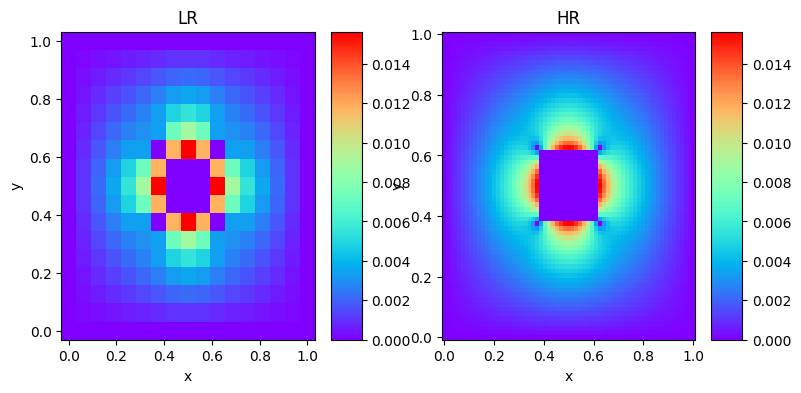

In [11]:
from scipy.sparse import csr_matrix, linalg, lil_matrix
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

N_low = 17
N_high = 65

h_low = 1/(N_low-1)
x_low = np.arange(0,1.0001,h_low)
y_low = np.arange(0,1.0001,h_low)
h_high = 1/(N_high-1)
x_high = np.arange(0,1.0001,h_high)
y_high = np.arange(0,1.0001,h_high)

A_low = create_bigA(N_low)
r_low = create_forcing_term(N_low)
u_low = linalg.spsolve(A_low,r_low)
u_whole_low = transfer_to_u_whole(N_low,u_low)

A_high = create_bigA(N_high)
r_high = create_forcing_term(N_high)
u_high = linalg.spsolve(A_high,r_high)
u_whole_high = transfer_to_u_whole(N_high,u_high)

fig = plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.pcolormesh(x_low, y_low, u_whole_low, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,2,2)
plt.pcolormesh(x_high, y_high, u_whole_high, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('HR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

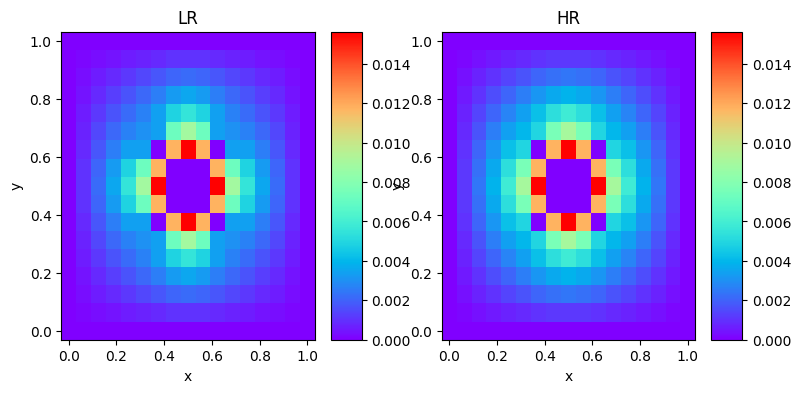

In [12]:
H = create_H(N_low,N_high)
downscaled = H.dot(u_high)
downscaled_whole = transfer_to_u_whole(N_low,downscaled)

fig = plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.pcolormesh(x_low, y_low, u_whole_low, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,2,2)
plt.pcolormesh(x_low, y_low, downscaled_whole, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('HR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [23]:

import scipy.ndimage

SR = scipy.ndimage.zoom(u_whole_low,(N_high/N_low,N_high/N_low))

In [40]:
def partial_bicubic(N_low,N_high,u):

    empty_rows_low = ((N_low-1) // 8) * 2 - 1
    num_values_low = (N_low-2-empty_rows_low-2)//2

    empty_rows_high = ((N_high-1) // 8) * 2 - 1
    num_values_high = (N_high-2-empty_rows_high-2)//2

    u_top_low = u[:(num_values_low+2)*N_low].reshape((num_values_low+2),N_low)

    u_bottom_low = u[-(num_values_low+2)*N_low:].reshape((num_values_low+2),N_low)

    u_left_low = np.zeros(empty_rows_low,2+num_values_low)
    u_right_low = np.zeros(empty_rows_low,2+num_values_low)

    for i in range(empty_rows_low):
        for j in range(2+num_values_low):
            u_left_low[i][j] = u[N_low*(2+num_values_low)+i*(N_low-empty_rows_low)+j] 
            u_right_low[i][j] = u[N_low*(2+num_values_low)+i*(N_low-empty_rows_low)+(N_low-empty_rows_low)//2+j]

    u_top_sr = scipy.ndimage.zoom(u_top_low,((2+num_values_high)/(2+num_values_low),N_high/N_low))
    u_bottom_sr = scipy.ndimage.zoom(u_bottom_low,((2+num_values_high)/(2+num_values_low),N_high/N_low))
    u_left_sr = scipy.ndimage.zoom(u_left_low,(empty_rows_high/empty_rows_low,(2+num_values_high)/(2+num_values_low)))
    u_right_sr = scipy.ndimage.zoom(u_right_low,(empty_rows_high/empty_rows_low,(2+num_values_high)/(2+num_values_low)))

    u_sr = np.zeros(((N_high*(N_high-empty_rows_high) + (N_high-empty_rows_high)*empty_rows_high),1))

    # top
    u_sr[:(num_values_high+2)*N_high] = u_top_sr.reshape(-1,1)

    # bottom
    u_sr[-(num_values_high+2)*N_high:] = u_bottom_sr.reshape(-1,1)

    # left
    for i in range(empty_rows_high):
        for j in range(2+num_values_high):
            u_sr[N_high*(2+num_values_high)+i*(N_high-empty_rows_high)+j] = u_left_sr[i][j]
            u_sr[N_high*(2+num_values_high)+i*(N_high-empty_rows_high)+(N_high-empty_rows_high)//2+j] = u_right_sr[i][j]

    return u_sr

In [41]:
u = u_low
empty_rows_low = ((N_low-1) // 8) * 2 - 1
num_values_low = (N_low-2-empty_rows_low-2)//2

empty_rows_high = ((N_high-1) // 8) * 2 - 1
num_values_high = (N_high-2-empty_rows_high-2)//2

u_top_low = u[:(num_values_low+2)*N_low].reshape((num_values_low+2),N_low)

u_bottom_low = u[-(num_values_low+2)*N_low:].reshape((num_values_low+2),N_low)

u_left_low = np.zeros((empty_rows_low,2+num_values_low))
u_right_low = np.zeros((empty_rows_low,2+num_values_low))

for i in range(empty_rows_low):
    for j in range(2+num_values_low):
        u_left_low[i][j] = u[N_low*(2+num_values_low)+i*(N_low-empty_rows_low)+j] 
        u_right_low[i][j] = u[N_low*(2+num_values_low)+i*(N_low-empty_rows_low)+(N_low-empty_rows_low)//2+j]

u_top_sr = scipy.ndimage.zoom(u_top_low,((2+num_values_high)/(2+num_values_low),N_high/N_low))
u_bottom_sr = scipy.ndimage.zoom(u_bottom_low,((2+num_values_high)/(2+num_values_low),N_high/N_low))
u_left_sr = scipy.ndimage.zoom(u_left_low,(empty_rows_high/empty_rows_low,(2+num_values_high)/(2+num_values_low)))
u_right_sr = scipy.ndimage.zoom(u_right_low,(empty_rows_high/empty_rows_low,(2+num_values_high)/(2+num_values_low)))

u_sr = np.zeros(((N_high*(N_high-empty_rows_high) + (N_high-empty_rows_high)*empty_rows_high),1))

# top
u_sr[:(num_values_high+2)*N_high] = u_top_sr.reshape(-1,1)

# bottom
u_sr[-(num_values_high+2)*N_high:] = u_bottom_sr.reshape(-1,1)

# left
for i in range(empty_rows_high):
    for j in range(2+num_values_high):
        u_sr[N_high*(2+num_values_high)+i*(N_high-empty_rows_high)+j] = u_left_sr[i][j]
        u_sr[N_high*(2+num_values_high)+i*(N_high-empty_rows_high)+(N_high-empty_rows_high)//2+j] = u_right_sr[i][j]

In [42]:
u_sr = transfer_to_u_whole(N_high,u_sr)

In [29]:
a = [1,2,3,4]
a[-2:]

[3, 4]

In [133]:
import pandas as pd

df = pd.DataFrame(H.todense())

df.to_excel('example_complex.xlsx', index=False)


In [20]:
error1 = abs(u_whole_low-downscaled_whole)
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)

SR L2 Error: 4.5371044324638025e-05


In [10]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import cv2
import math
from tqdm import tqdm
from tqdm.std import trange
from torch.utils.data import dataloader
from scipy.sparse import csr_matrix, linalg, lil_matrix


def create_subA(N):

    subA = lil_matrix((N,N))

    subA[0,0] = 1
    subA[-1,-1] = 1

    for i in range(1,N-1):
        subA[i,i-1] = -1
        subA[i,i] = 6
        subA[i,i+1] = -1

    return subA


def create_subB(N):
    subB = lil_matrix((N,N))

    for i in range(1,N-1):
        subB[i,i] = -1

    return subB


def create_subI(N):

    subI = lil_matrix((N,N))

    for i in range(N):
        subI[i,i] = 1

    return subI


def create_bigA(N):

    bigA = lil_matrix((N**2,N**2))

    bigA[0:N,0:N] = create_subI(N)
    bigA[N*(N-1):N*N,N*(N-1):N*N] = create_subI(N)

    for i in range(1,N-1):
        bigA[N*i:N*(i+1),N*(i-1):N*i] = create_subB(N)
        bigA[N*i:N*(i+1),N*i:N*(i+1)] = create_subA(N)
        bigA[N*i:N*(i+1),N*(i+1):N*(i+2)] = create_subB(N)

    return bigA


def create_bigB(N):

    bigB = lil_matrix((N**2,N**2))

    for i in range(1,N-1):
        bigB[N*i:N*(i+1),N*i:N*(i+1)] = create_subB(N)

    return bigB


def create_bigI(N):

    bigI = lil_matrix((N**2,N**2))

    for i in range(N**2):
        bigI[i,i] = 1

    return bigI


def create_A(N):

    A = lil_matrix((N**3,N**3))

    h = 1/(N-1)

    empty_rows = ((N-1) // 8) * 2 - 1
    num_values = (N-2-empty_rows-2)//2

    A[0:N**2,0:N**2] = create_bigI(N)
    A[(N**2)*(N-1):N**3,(N**2)*(N-1):N**3] = create_bigI(N)

    bigA = create_bigA(N)
    bigB = create_bigB(N)

    for i in range(1,N-1):
        A[(N**2)*i:(N**2)*(i+1),(N**2)*(i-1):(N**2)*i] = bigB
        A[(N**2)*i:(N**2)*(i+1),(N**2)*i:(N**2)*(i+1)] = bigA
        A[(N**2)*i:(N**2)*(i+1),(N**2)*(i+1):(N**2)*(i+2)] = bigB

    for i in range(1+num_values,2+num_values+empty_rows+1):
        for j in range(1+num_values,2+num_values+empty_rows+1):
            for k in range(1+num_values,2+num_values+empty_rows+1):
                A[i*N**2+j*N+k,:] = 0
                A[i*N**2+j*N+k,i*N**2+j*N+k] = 1

    return A


def create_forcing_term(N, a, b, c, d):

    h = 1/(N-1)
    x = np.arange(0,1.0001,h)
    y = np.arange(0,1.0001,h)
    z = np.arange(0,1.0001,h)

    empty_rows = ((N-1) // 8) * 2 - 1
    num_values = (N-2-empty_rows-2)//2

    r = np.zeros(N**3)

    # top & bottom face

    i = 1+num_values

    for j in range(1+num_values,2+num_values+empty_rows+1):
        for k in range(1+num_values,2+num_values+empty_rows+1):
            position = N**2 * i + N * j + k
            r[position] = 1

    i = 2+num_values+empty_rows

    for j in range(1+num_values,2+num_values+empty_rows+1):
        for k in range(1+num_values,2+num_values+empty_rows+1):
            position = N**2 * i + N * j + k
            r[position] = 1

    # left & right face

    j = 1+num_values

    for i in range(1+num_values,2+num_values+empty_rows+1):
        for k in range(1+num_values,2+num_values+empty_rows+1):
            position = N**2 * i + N * j + k
            r[position] = 1

    j = 2+num_values+empty_rows

    for i in range(1+num_values,2+num_values+empty_rows+1):
        for k in range(1+num_values,2+num_values+empty_rows+1):
            position = N**2 * i + N * j + k
            r[position] = 1

    # front & back face

    k = 1+num_values

    for i in range(1+num_values,2+num_values+empty_rows+1):
        for j in range(1+num_values,2+num_values+empty_rows+1):
            position = N**2 * i + N * j + k
            r[position] = 1

    k = 2+num_values+empty_rows

    for i in range(1+num_values,2+num_values+empty_rows+1):
        for j in range(1+num_values,2+num_values+empty_rows+1):
            position = N**2 * i + N * j + k
            r[position] = 1
    
    return r


def generate_data(N,a,b,c,d):

    # Initialisation
    h = 1/(N-1)
    x = np.arange(0,1.0001,h)
    y = np.arange(0,1.0001,h)
    z = np.arange(0,1.0001,h)
    
    # Work out the matrix A
    A = create_A(N)
        
    # Work out the forcing term r
    r = create_forcing_term(N,a,b,c,d)

    w = linalg.spsolve(A,r).reshape((N,N,N))
    
    return w, r, A, x, y, z


In [2]:
N_low = 17
N_high = 65
scale = 4
a, b, c, d = 1,1,1,0

h_low = 1/(N_low-1)
x_low = np.arange(0,1.0001,h_low)
y_low = np.arange(0,1.0001,h_low)
z_low = np.arange(0,1.0001,h_low)

h_high = 1/(N_high-1)
x_high = np.arange(0,1.0001,h_high)
y_high = np.arange(0,1.0001,h_high)
z_high = np.arange(0,1.0001,h_high)

In [3]:
w_low, r_low, A_low, x_low, y_low, z_low = generate_data(N_low,a,b,c,d)
w_high, r_high, A_high, x_high, y_high, z_high = generate_data(N_high,a,b,c,d)

/tmp/ipykernel_1412385/122411436.py:187: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  w = linalg.spsolve(A,r).reshape((N,N,N))


In [6]:
empty_rows_low = ((N_low-1) // 8) * 2 - 1
num_values_low = (N_low-2-empty_rows_low-2)//2
empty_rows_high = ((N_high-1) // 8) * 2 - 1
num_values_high = (N_high-2-empty_rows_high-2)//2

In [7]:
w_high.shape

(65, 65, 65)

In [12]:
import scipy.ndimage
def bicubic_3D(N_high,N_low,w_low):
        
    w_sr = np.zeros((N_high,N_high,N_high))

    # Top block

    w_low_top = w_low[0:2+num_values_low,:,:]
    w_sr[0:2+num_values_high,:,:] = scipy.ndimage.zoom(w_low_top, [(2+num_values_high)/(2+num_values_low),N_high/N_low,N_high/N_low], order=3)

    # Bottom block

    w_low_bottom = w_low[-2-num_values_low:,:,:]
    w_sr[-2-num_values_high:,:,:] = scipy.ndimage.zoom(w_low_bottom, [(2+num_values_high)/(2+num_values_low),N_high/N_low,N_high/N_low], order=3)

    # Front block

    w_low_front = w_low[2+num_values_low:2+num_values_low+empty_rows_low,:,0:2+num_values_low]
    w_sr[2+num_values_high:2+num_values_high+empty_rows_high,:,0:2+num_values_high] = scipy.ndimage.zoom(w_low_front, [empty_rows_high/empty_rows_low,N_high/N_low,(2+num_values_high)/(2+num_values_low)], order=3)

    # Back block

    w_low_back = w_low[2+num_values_low:2+num_values_low+empty_rows_low,:,-2-num_values_low:]
    w_sr[2+num_values_high:2+num_values_high+empty_rows_high,:,-2-num_values_high:] = scipy.ndimage.zoom(w_low_back, [empty_rows_high/empty_rows_low,N_high/N_low,(2+num_values_high)/(2+num_values_low)], order=3)

    # Left block

    w_low_left = w_low[2+num_values_low:2+num_values_low+empty_rows_low,0:2+num_values_low,2+num_values_low:2+num_values_low+empty_rows_low]
    w_sr[2+num_values_high:2+num_values_high+empty_rows_high,0:2+num_values_high,2+num_values_high:2+num_values_high+empty_rows_high] = scipy.ndimage.zoom(w_low_left, [empty_rows_high/empty_rows_low,(2+num_values_high)/(2+num_values_low),empty_rows_high/empty_rows_low], order=3)

    # Right block

    w_low_right = w_low[2+num_values_low:2+num_values_low+empty_rows_low,-2-num_values_low:,2+num_values_low:2+num_values_low+empty_rows_low]
    w_sr[2+num_values_high:2+num_values_high+empty_rows_high,-2-num_values_high:,2+num_values_high:2+num_values_high+empty_rows_high] = scipy.ndimage.zoom(w_low_right, [empty_rows_high/empty_rows_low,(2+num_values_high)/(2+num_values_low),empty_rows_high/empty_rows_low], order=3)

    return w_sr

In [13]:
w_sr.shape

(65, 65, 65)

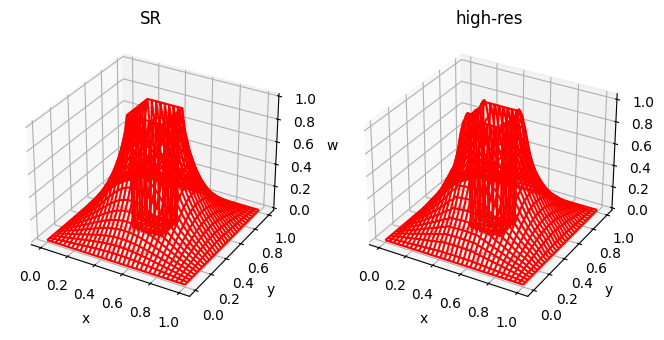

In [14]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_high, y_high)
ax1.plot_wireframe(X, Y, w_high[32],color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('SR')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, w_sr[32],color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

In [15]:
error1 = abs(w_high - w_sr)
MSE = (error1**2).sum()/error1.shape[0]**2
print('SR L2 Error:', MSE)

SR L2 Error: 0.02568561134099354
